# HCA Model Criticism

In [3]:
from scvi_criticism import PPC, PPCPlot
import scvi
import anndata
import pandas as pd
import numpy as np
import scanpy as sc
import torch
import gc
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import mplscience
import seaborn as sns
import scipy
from pathlib import Path
import math
from scvi.data._download import _download
from scvi.data import cellxgene
import os
from scvi.model.base import ArchesMixin

scvi.settings.seed = 1

# plotting commands for the styling
# sns.reset_orig()
mplscience.set_style(reset_current=True, name="default")

%load_ext autoreload
%autoreload 2

Global seed set to 0
Global seed set to 1


## 1️⃣ Get the data and train models

Following [this](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/api_overview.html) tutorial, we will use the HCA dataset.

The dataset used is a subset of the heart cell atlas dataset:
Litviňuková, M., Talavera-López, C., Maatz, H., Reichart, D., Worth, C. L., Lindberg, E. L., … & Teichmann, S. A. (2020). Cells of the adult human heart. Nature, 588(7838), 466-472.

Let's train the model as usual. Also save the model and data on disk as we'll need them later.

In [83]:
local_dir = "/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HCA"

In [5]:
adata = scvi.data.heart_cell_atlas_subsampled(save_path=local_dir)
sc.pp.filter_genes(adata, min_counts=3)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="cell_source",
)

INFO     File /Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HCA/hca_subsampled_20k.h5ad already 
         downloaded                                                                                                


Train the model.

In [9]:
good_model_path = f"{local_dir}/good_model"

In [6]:
adata2 = adata.copy()

In [7]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"],
)
model = scvi.model.SCVI(adata)
model.train()

model.save(good_model_path, save_anndata=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [14:35<00:00,  2.05s/it, loss=282, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [14:35<00:00,  2.19s/it, loss=282, v_num=1]


ValueError: /Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HCA/good_model already exists. Please provide another directory for saving.

Train a bad model -- not enough epochs.

In [8]:
bad_model_1_path = f"{local_dir}/bad_model_1"

In [10]:
adata = adata2.copy()

In [11]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"],
)
model_bad_1 = scvi.model.SCVI(adata)
model_bad_1.train(max_epochs=5)

model_bad_1.save(bad_model_1_path, save_anndata=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 5/5: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it, loss=295, v_num=1]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it, loss=295, v_num=1]


Train a bad model -- too small of a latent space.

In [10]:
bad_model_2_path = f"{local_dir}/bad_model_2"

In [13]:
adata = adata2.copy()

In [14]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"],
)
model_bad_2 = scvi.model.SCVI(adata, n_latent=2)
model_bad_2.train()

model_bad_2.save(bad_model_2_path, save_anndata=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [13:34<00:00,  2.00s/it, loss=291, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [13:34<00:00,  2.04s/it, loss=291, v_num=1]


## 2️⃣ Evaluate

In [81]:
temp_fig_dir = "/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/temp_figs"

Evaluate the good model

In [19]:
model = scvi.model.SCVI.load(good_model_path)

INFO     File /Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HCA/good_model/model.pt already     
         downloaded                                                                                                


INFO     model=SCVI | metric=cv_cell | n_cells=18641:                                                              
         Mean Absolute Error=0.99,                                                                                 
         Pearson correlation=0.73                                                                                  
         Spearman correlation=0.77                                                                                 
         r^2=0.51                                                                                                  
                                                                                                                   


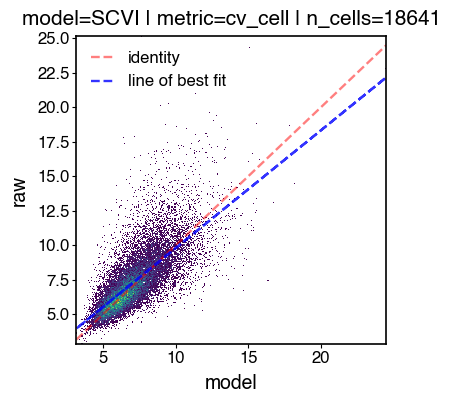

In [20]:
# run ppc+cv
models_dict = {"SCVI": model}
ppc = PPC(adata, models_dict, count_layer_key="counts", n_samples=2)
ppc.coefficient_of_variation("features")

ppc_plt = PPCPlot(ppc)
ppc_plt.plot_cv(model_name="SCVI", cell_wise=True, plt_type="hist2d")

fig_path = f'{temp_fig_dir}/hca_good_model_ppc_cv_cell.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")

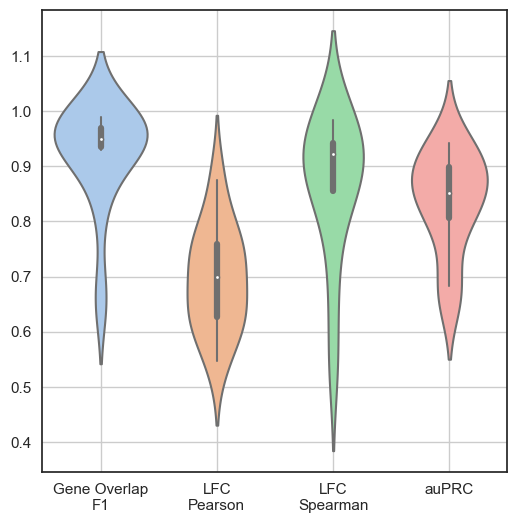

In [20]:
# run ppc+DE
models_dict = {"SCVI": model}
ppc = PPC(adata, models_dict, n_samples=2)
ppc.differential_expression(de_groupby="cell_type", p_val_thresh=0.2)

ppc_plt = PPCPlot(ppc)
ppc_plt.plot_diff_exp(
    "SCVI",
    plot_kind="summary_violin",
)
fig_path = f'{temp_fig_dir}/good_model_de_summary_barplot.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

Evaluate the bad model 1

In [25]:
model = scvi.model.SCVI.load(bad_model_1_path)

INFO     File /Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HCA/bad_model_1/model.pt already    
         downloaded                                                                                                


INFO     model=SCVI | metric=cv_cell | n_cells=18641:                                                              
         Mean Absolute Error=1.30,                                                                                 
         Pearson correlation=0.53                                                                                  
         Spearman correlation=0.60                                                                                 
         r^2=0.18                                                                                                  
                                                                                                                   


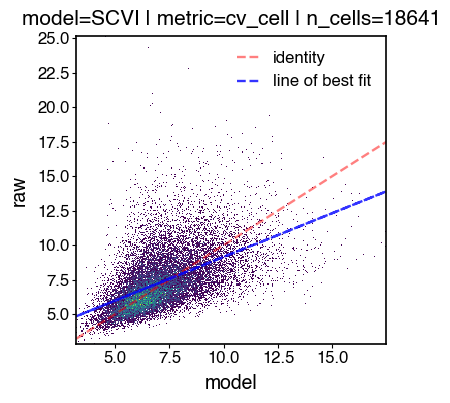

In [26]:
# run ppc+cv for bad model 1
models_dict = {"SCVI": model}
ppc = PPC(adata, models_dict, count_layer_key="counts", n_samples=2)
ppc.coefficient_of_variation("features")

ppc_plt = PPCPlot(ppc)
ppc_plt.plot_cv(model_name="SCVI", cell_wise=True, plt_type="hist2d")

fig_path = f'{temp_fig_dir}/hca_bad_model_1_ppc_cv_cell.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")

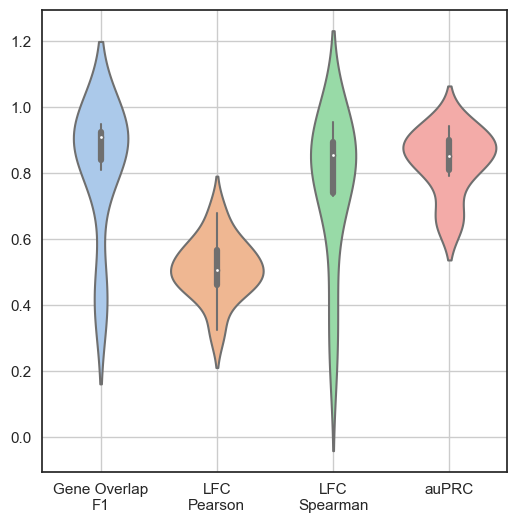

In [35]:
# run ppc+DE for bad model 1
models_dict = {"SCVI": model}
ppc = PPC(adata, models_dict, n_samples=2)
ppc.differential_expression(de_groupby="cell_type", p_val_thresh=0.2)

ppc_plt = PPCPlot(ppc)
ppc_plt.plot_diff_exp(
    "SCVI",
    plot_kind="summary_violin",
)
fig_path = f'{temp_fig_dir}/hca_bad_model_1_ppc_cv_cell.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

Evaluate the bad model 2

In [23]:
model = scvi.model.SCVI.load(bad_model_2_path)

INFO     File /Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HCA/bad_model_2/model.pt already    
         downloaded                                                                                                


INFO     model=SCVI | metric=cv_cell | n_cells=18641:                                                              
         Mean Absolute Error=1.09,                                                                                 
         Pearson correlation=0.66                                                                                  
         Spearman correlation=0.73                                                                                 
         r^2=0.40                                                                                                  
                                                                                                                   


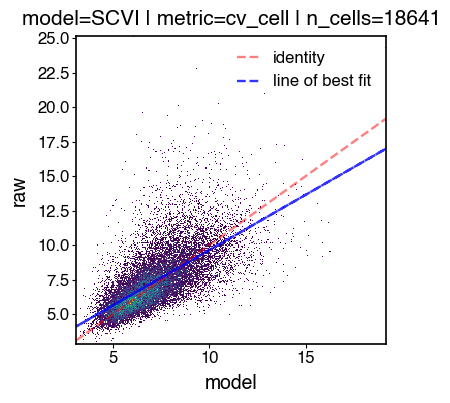

In [24]:
# run ppc+cv for bad model 2
models_dict = {"SCVI": model}
ppc = PPC(adata, models_dict, count_layer_key="counts", n_samples=2)
ppc.coefficient_of_variation("features")

ppc_plt = PPCPlot(ppc)
ppc_plt.plot_cv(model_name="SCVI", cell_wise=True, plt_type="hist2d")

fig_path = f'{temp_fig_dir}/hca_bad_model_2_ppc_cv_cell.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")

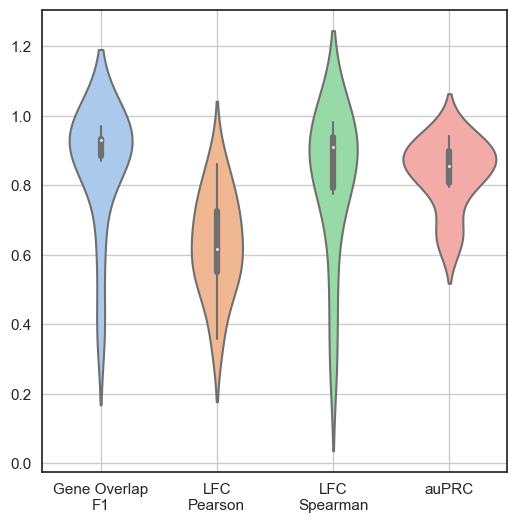

In [27]:
# run ppc+DE for bad model 2
models_dict = {"SCVI": model}
ppc = PPC(adata, models_dict, n_samples=2)
ppc.differential_expression(de_groupby="cell_type", p_val_thresh=0.2)

ppc_plt = PPCPlot(ppc)
ppc_plt.plot_diff_exp(
    "SCVI",
    plot_kind="summary_violin",
)
fig_path = f'{temp_fig_dir}/bad_model_2_de_summary_barplot.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

## 3️⃣ Visualize box plots

In [84]:
good_model = scvi.model.SCVI.load(f"{local_dir}/good_model")
bad_model_1 = scvi.model.SCVI.load(f"{local_dir}/bad_model_1")
bad_model_2 = scvi.model.SCVI.load(f"{local_dir}/bad_model_2")

INFO     File /Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HCA/good_model/model.pt already     
         downloaded                                                                                                
INFO     File /Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HCA/bad_model_1/model.pt already    
         downloaded                                                                                                
INFO     File /Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HCA/bad_model_2/model.pt already    
         downloaded                                                                                                


In [85]:
models_dict = {
    "good_model": good_model,
    "bad_model_1": bad_model_1,
    "bad_model_2": bad_model_2,
}
ppc = PPC(adata, models_dict, n_samples=2)
ppc.differential_expression(de_groupby="cell_type", p_val_thresh=0.2)

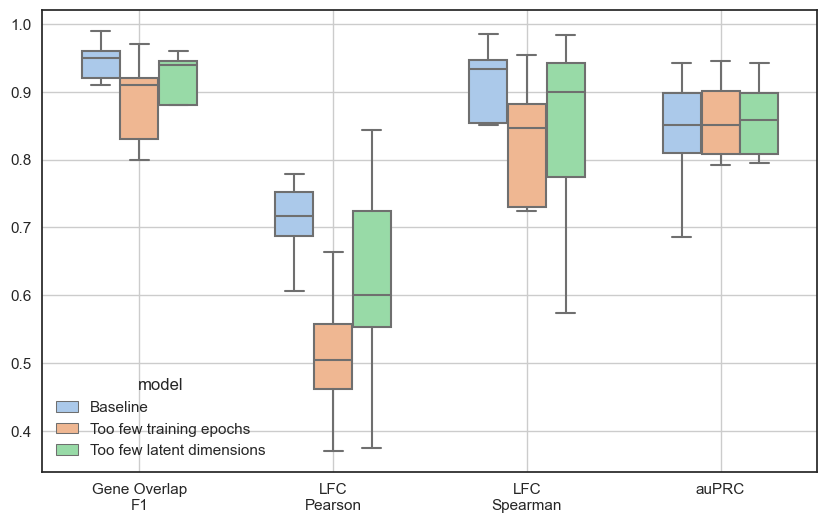

In [94]:
de_metrics = ppc.metrics["diff_exp"]
if "lfc_mae" in de_metrics.columns:
    del de_metrics["lfc_mae"]  # not on the same scale as the other ones
if "roc_auc" in de_metrics.columns:
    del de_metrics["roc_auc"]  # skip this for now, TODO fix/remove

# inspired by https://stackoverflow.com/a/68268937
sns.set(rc={"figure.figsize": (10, 6)})
sns.set_theme(style="white")
de_metrics = de_metrics.melt(id_vars=['model'], value_vars=['gene_overlap_f1', 'lfc_pearson', 'lfc_spearman', 'pr_auc'], var_name='Metric', value_name='Value')
metric_names = {
    "gene_overlap_f1": "Gene Overlap\nF1",
    "lfc_pearson": "LFC\nPearson",
    "lfc_spearman": "LFC\nSpearman",
    "pr_auc": "auPRC",
}
model_names = {
    "good_model": "Baseline",
    "bad_model_1": "Too few training epochs",
    "bad_model_2": "Too few latent dimensions",
}
for k,v in metric_names.items():
    de_metrics["Metric"] = de_metrics["Metric"].str.replace(k, v)
for k,v in model_names.items():
    de_metrics["model"] = de_metrics["model"].str.replace(k, v)
b = sns.boxplot(
    data=de_metrics,
    x='Metric',
    y='Value',
    hue='model',
    showfliers = False,
    width=.6,
    palette=sns.color_palette("pastel"),
)
b.set(xlabel=None, ylabel=None)
plt.grid()

fig_path = f'{temp_fig_dir}/model_comparison_summary_barplot.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()